# Have the World Become Less Peaceful? An Emirical Analysis of Geopolitical Trends

In this project, we analyze the development of war and peace in the world. In particular, we make a few charts to investigate our main question; *Have the world beomce less peaceful?* To answer this question we source data from the following sources: 
1. The geopolitical risk index (GPR) developed by [Caldara and Iacoviello (2022)](https://www.aeaweb.org/articles?id=10.1257/aer.20191823)
2. The number of deaths in armed conflicts from the Uppsala Conflict Data Program. Link: [Our World in Data](https://ourworldindata.org/explorers/conflict-data?facet=none&Conflict+type=All+armed+conflicts&Measure=Conflict+deaths&Conflict+sub-type=By+sub-type&Data+source=Uppsala+Conflict+Data+Program&Sub-measure=Regional+data&country=~OWID_WRL)
3. The population of different countries and military spending as a percentage of GDP from the World Bank
4. State Preferences from UN voting data in the form of ideal points estimated in [Bailey, Strezhnev and Voeten (2017)](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/LEJUQZ)

The GPR index is meant to measure the geopolitical risk in the world using newspaper data and the state preferences are expressed as so-called ideal points, where a smaller value indicates a more left-leaning country and a larger ideal point more right-leaning.

Our project is structured around five differnet plots, which each tell part of the story about war and peace in the world. The five plots are:

1. A heatmap showing the country-level GPR for 44 countries since 1990
2. A ridge plot showing the half-decade average of global GPR since 1900
3. A line plot showing the development in state preferences since 1946
4. A scatter plot showing the millitary spending and ideal points of different states
5. A time plot showing the deaths from armed conflicts since 1989

Imports and set magics:

In [48]:
# Uncomment to install packages
# %pip install matplotlib-venn
# %pip install joypy
# %pip install pycountry_convert
# %pip install "altair[all]"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
import datetime
from matplotlib_venn import venn2
from joypy import joyplot
from matplotlib import cm
import altair as alt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Chart 1: A Time of Waning Peace -  Country-Level GPR Since 1990

To create a heatmap of the country level GPR, we use the raw data from Caldara and Iacoviello. We then call the class ``gpr_clean`` from `dataproject.py`. Applying this class to the data i) drops unwanted columns, ii) shifts the from wide to long and iii) the standardize the indices by subtracting the mean and dividing by the standard deviation. The class returns a cleaned dataset `df_gpr`. To plot the heatmap, we call `heatmap_gpr`.

In [79]:
# Load data
filename = 'GPR_quarter.xlsx'
gpr_raw = pd.read_excel(filename, index_col=0, parse_dates=True)

# Clean data using the gpr_clean class
cleaner = dataproject.gpr_clean(gpr_raw) # Create an instance of the gpr_clean class
df_gpr = cleaner() # Returns the cleaned DataFrame

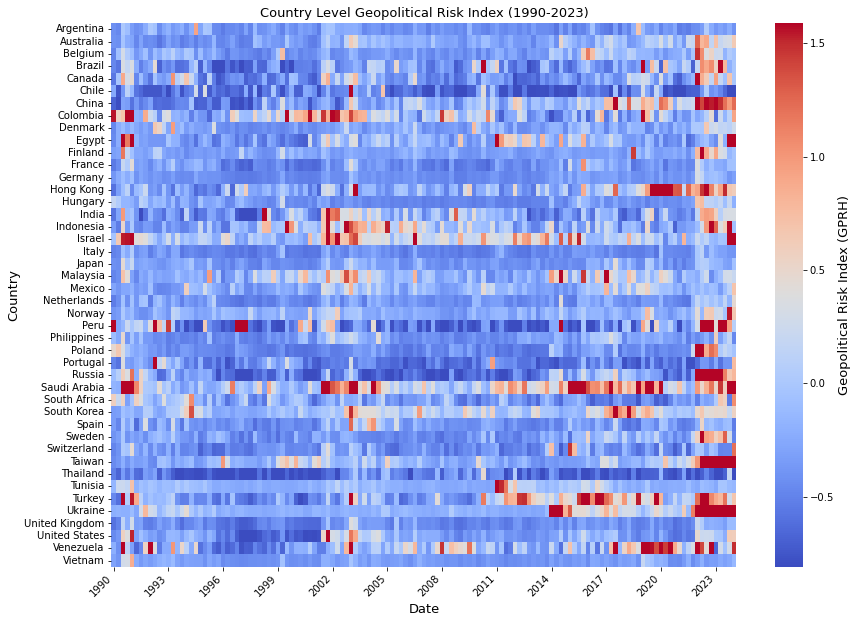

In [80]:
# Call the heatmap plot function from the dataproject module
dataproject.heatmap_gpr(df_gpr) 

# Chart 2: A new 1915s? - Average Global GPR Index Since 1900 by Five-Year Intervals

We use the `df_gpr` DataFrame together with the Python package `joypy` to create a ridge plot.

<Figure size 432x288 with 0 Axes>

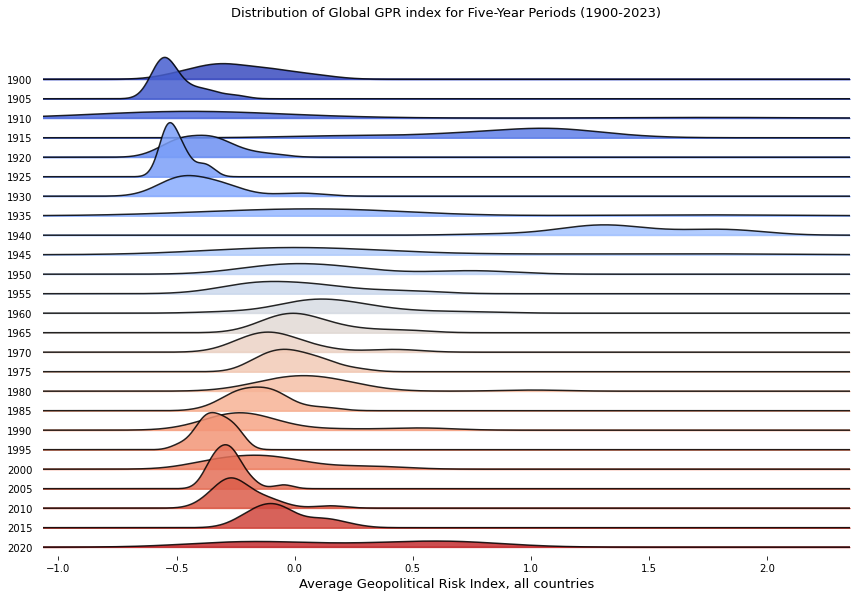

In [81]:
dataproject.ridge_gpr(df_gpr)

# Chart 3: The Divergence of the Blocks - Geopolitical State Preferences Since 1947

We use the `idealpoint_clean` class to clean the raw data from Bailey et al. (2017). This class drops unwanted columns. We then call the `lineplot_idealpoints` function. This function calculates the average ideal point over time for the left- and right-leaning countries. Left-leaning countries have an ideal point below 0 and right leaning countries one above 0.

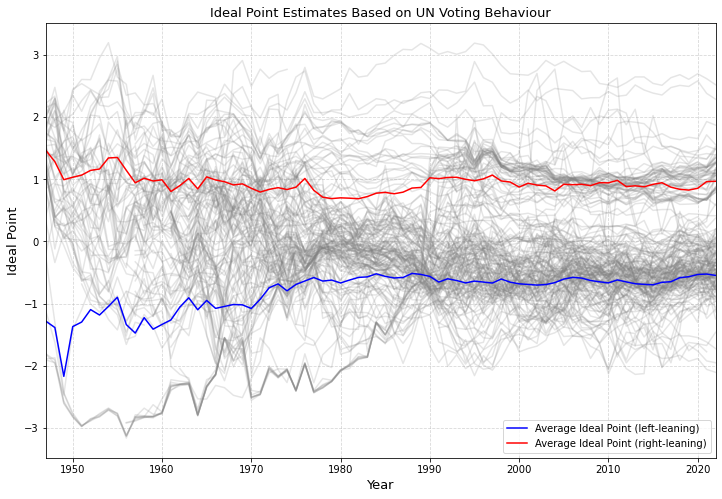

In [83]:
filename_idealpoint = 'IdealpointestimatesAll_Sep2023.csv'
idealpoint_raw = pd.read_csv(filename_idealpoint, delimiter=';')

cleaner = dataproject.idealpoint_clean(idealpoint_raw)
df_idealpoint = cleaner()
dataproject.lineplot_idealpoints(df_idealpoint)

# Chart 4: A Tale of Two Blocks - Ideal Points Estimates and Military Spending

To create this plot, we merge the ideal point data with data for population level data and millitary spending data from the World Bank's Development Indicators. The cleaning and merging of data is done with the function `scatter_mil_ideal`. This function use the package `pycountry_convert`, which helps us map ISO 3-letter country code into a corresponding country.

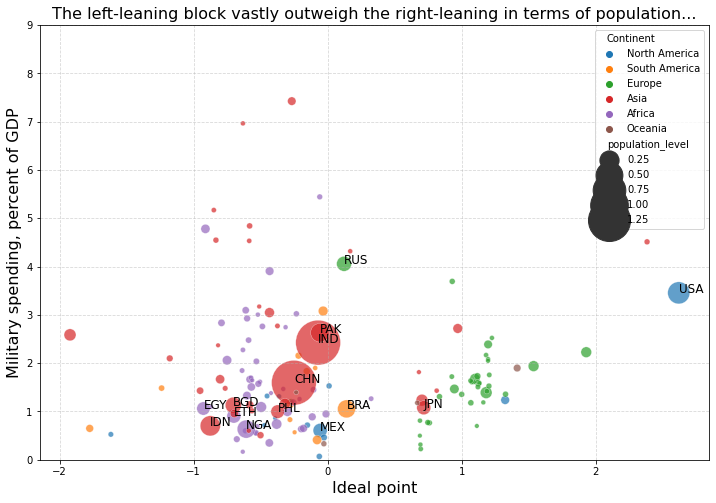

In [6]:
df_military_gdp_spend = pd.read_csv('military_gdp_spend.csv', index_col=1, skiprows=4) # Millitary spend as % of GDP
df_population = pd.read_csv('population.csv', index_col=1, skiprows=4) # Population level, 2022
df_idealpoint = pd.read_csv('IdealpointestimatesAll_Sep2023.csv', delimiter=';') # Ideal point estimates

dataproject.scatter_mil_ideal(df_military_gdp_spend, df_population, df_idealpoint)

# Chart 5: Deaths in Interstate Wars Are Back - Deaths in Armed Conflict by Type

Finally, we plot the deaths from armed conflicts as an interactive plot. To do this, we use the `altair` package. This package lets us easily create an interactive plot showing the deaths by different types of conclict.

In [95]:
df_war_deaths = pd.read_csv('war_deaths.csv') # War deaths
dataproject.lineplot_war_deaths(df_war_deaths)

alt.Chart(...)

# Conclusion

Based on our five charts, we conclude that the world does actually seem to have become less peacefull. In particular is the GPR index very high in many countries as seen by chart 1. We also see that the global GPR since 2020 have been relativly high. Chart 3 tells us a story about global geopolitical preferences begining to diverge. In chart 4, we see that the geopolitical stance of countries is largly determined by their geographical location. The chart also reveals that a large fraction of the world's population is located in geopolitically more left-leaning countries. In chart 5, we show that the sad reality of war, namly deaths, have also been rising. In particular, the deaths from interstate wars were the highest in 2022.